## Système de recommadation Hybride : Content-based sur le genre (Action, Comédie ...) et Collaboratif item-item (historique de goût de l'utilisateur)


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
!pip -q install scikit-surprise

In [4]:
from google.colab import files
import zipfile

# Uploader ton fichier zip
uploaded = files.upload()

# Dézipper dans Colab
with zipfile.ZipFile("ml-100k.zip", "r") as zip_ref:
    zip_ref.extractall("ml-100k")


Saving ml-100k.zip to ml-100k.zip


## Chargement des fichiers

In [5]:
import pandas as pd

# Charger les notes (ratings)
ratings = pd.read_csv("ml-100k/ml-100k/u.data",
                      sep="\t",
                      names=["userId", "movieId", "rating", "timestamp"])

# Charger les films
movies = pd.read_csv("ml-100k/ml-100k/u.item",
                     sep="|",
                     encoding="latin-1",
                     usecols=[0,1,2,3],
                     names=["movieId", "title", "release_date", "genres"])

print("Aperçu des notes :")
print(ratings.head())

print("\nAperçu des films :")
print(movies.head())

Aperçu des notes :
   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596

Aperçu des films :
   movieId              title release_date  genres
0        1   Toy Story (1995)  01-Jan-1995     NaN
1        2   GoldenEye (1995)  01-Jan-1995     NaN
2        3  Four Rooms (1995)  01-Jan-1995     NaN
3        4  Get Shorty (1995)  01-Jan-1995     NaN
4        5     Copycat (1995)  01-Jan-1995     NaN


In [6]:
import pandas as pd

# Charger la liste des genres (officielle dans MovieLens)
genre_labels = [
    "unknown", "Action", "Adventure", "Animation",
    "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
    "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
    "Thriller", "War", "Western"
]

# Charger le fichier complet
movies = pd.read_csv("ml-100k/ml-100k/u.item", sep="|", encoding="latin-1",
                     header=None)

# Garder id, titre, date
movies = movies.iloc[:, :24]  # movieId + title + release_date + 19 genres

movies.columns = ["movieId", "title", "release_date", "video_release_date", "imdb_url"] + genre_labels

# Fusionner les genres en une seule colonne texte
def extract_genres(row):
    return [g for g, val in zip(genre_labels, row[3:]) if val == 1]

movies["genres"] = movies.apply(extract_genres, axis=1)

print(movies.head()[["movieId","title","genres"]])

   movieId              title                               genres
0        1   Toy Story (1995)         [Comedy, Crime, Documentary]
1        2   GoldenEye (1995)     [Animation, Children's, Western]
2        3  Four Rooms (1995)                            [Western]
3        4  Get Shorty (1995)  [Animation, Documentary, Film-Noir]
4        5     Copycat (1995)          [Drama, Film-Noir, Western]


## Content-based sur les genres : Similarité cosinus sur le genre des films

In [7]:
# movies doit contenir: movieId, title, genres (liste)
assert {"movieId","title","genres"}.issubset(movies.columns)

# One-hot : binarisation des miltiples label du genre
mlb = MultiLabelBinarizer()
G = mlb.fit_transform(movies["genres"])
genre_features = pd.DataFrame(G, columns=mlb.classes_, index=movies.index)

# Similarité cosinus entre films (sur genres)
sim_content = cosine_similarity(genre_features.values)
np.fill_diagonal(sim_content, 0.0)  # on ignore l'auto-similarité

# mapping index : movieId / title
idx_by_title = {t:i for i, t in enumerate(movies["title"].tolist())}

def recommend_similar(title, k=10):
    i = idx_by_title.get(title)
    if i is None:
        raise ValueError("Titre non trouvé.")
    sims = sim_content[i]
    top_idx = sims.argsort()[::-1][:k]
    return (movies.loc[top_idx, ["movieId","title"]]
                  .assign(score=sims[top_idx])
                  .sort_values("score", ascending=False)
                  .reset_index(drop=True))

# Ancre/film de référence: les fils similaire à Toy Story seront recommandés
recommend_similar("Toy Story (1995)", k=10)


,movieId,title,score
0,422,Aladdin and the King of Thieves (1996),1.000000
1,1219,"Goofy Movie, A (1995)",0.866025
2,95,Aladdin (1992),0.866025
3,138,D3: The Mighty Ducks (1996),0.816497
4,1412,Land Before Time III: The Time of the Great Gi...,0.816497
5,1032,Little Big League (1994),0.816497
6,189,"Grand Day Out, A (1992)",0.816497
7,139,"Love Bug, The (1969)",0.816497
8,261,Air Bud (1997),0.816497
9,1066,Balto (1995),0.816497


***Si un film a un score proche de  1 ce qui veut dire que le genre du film est similaire au genre le l'Ancre.***

## Collaboratif item-item : en claire, il sagit de trouver les films que l'utilisateur pourrait aimer en se basant son historique de films : ici, l'ancre n'est pas un film mais tout le profil de goût de l'utilisateur

In [8]:
# ratings: userId, movieId, rating, timestamp
assert {"userId","movieId","rating"}.issubset(ratings.columns)

# Matrice utilisateur-film
R = ratings.pivot_table(index="userId", columns="movieId", values="rating")

# Centrage par utilisateur pour atténuer l'effet "utilisateur généreux/sévère"
R_centered = R.sub(R.mean(axis=1), axis=0).fillna(0)

# Similarité cosinus entre items (films)
from sklearn.metrics.pairwise import cosine_similarity
item_sim = cosine_similarity(R_centered.T.values)  # colonnes=films
np.fill_diagonal(item_sim, 0.0)

# Aligne les index/colonnes
movie_ids = R_centered.columns.to_list()
idx_by_movieId = {mid:i for i, mid in enumerate(movie_ids)}

def recommend_cf_for_user(user_id, k=10, min_ratings_user=3):
    """Recommande via item-item en pondérant par les notes de l'utilisateur."""
    if user_id not in R.index:
        raise ValueError("userId inconnu.")
    user_row = R.loc[user_id].dropna()
    if len(user_row) < min_ratings_user:
        # fallback: films populaires
        pop = (ratings.groupby("movieId")["rating"]
                      .agg(["count","mean"])
                      .query("count>=50")
                      .sort_values(["mean","count"], ascending=False)
                      .head(k))
        out = movies.merge(pop, left_on="movieId", right_index=True, how="inner")
        return out[["movieId","title","mean","count"]].rename(columns={"mean":"score"})

    # score = somme(sim(item, films_vus) * (rating - moyenne_user))
    user_mean = R.loc[user_id].mean()
    scores = np.zeros(len(movie_ids))

    for seen_mid, r in user_row.items():
        j = idx_by_movieId.get(seen_mid)
        if j is None:
            continue
        scores += item_sim[j] * (r - user_mean)

    # On met à -inf les films déjà vus
    seen_idx = [idx_by_movieId[m] for m in user_row.index if m in idx_by_movieId]
    scores[seen_idx] = -np.inf

    top_idx = np.argsort(scores)[::-1][:k]
    top_movie_ids = [movie_ids[i] for i in top_idx]
    out = movies[movies["movieId"].isin(top_movie_ids)].copy()
    out["score"] = [scores[idx_by_movieId[mid]] for mid in out["movieId"]]
    return out.sort_values("score", ascending=False)[["movieId","title","score"]].reset_index(drop=True)

# Exemple
recommend_cf_for_user(user_id=1, k=10)


,movieId,title,score
0,483,Casablanca (1942),22.505094
1,318,Schindler's List (1993),21.118097
2,603,Rear Window (1954),20.756683
3,357,One Flew Over the Cuckoo's Nest (1975),20.055295
4,474,Dr. Strangelove or: How I Learned to Stop Worr...,19.672989
5,479,Vertigo (1958),18.352249
6,511,Lawrence of Arabia (1962),18.018791
7,651,Glory (1989),17.714608
8,427,To Kill a Mockingbird (1962),17.423146
9,480,North by Northwest (1959),16.975307


***Les scores ne sont pas bornés à 1 (contrairement à la similarité cosinus du content-based) car on additionne des contributions; d’où des valeurs > 1.
On remarque des classiques (Casablanca, Schindler’s List, Rear Window) ça reflète probablement le profil de l’utilisateur : il/elle a noté des films proches (drame / classiques / Hitchcock), donc l’algorithme pousse ces titres***

## Combinaison hybride des deux (poids α).

In [9]:
from sklearn.preprocessing import minmax_scale

def hybrid_recommend(user_id, k=10, alpha=0.5, anchor_title=None, shortlist=200):
    # 1) Score CF pour l'utilisateur (sur tous les films)
    cf_df = recommend_cf_for_user(user_id, k=shortlist, min_ratings_user=3)
    cf_scores = dict(zip(cf_df["movieId"], cf_df["score"]))

    # 2) Score contenu via un film ancre
    if anchor_title is None:
        # choisir l’un des films les mieux notés par l’utilisateur comme ancre
        user_hist = ratings.query("userId == @user_id").sort_values("rating", ascending=False)
        if user_hist.empty:
            raise ValueError("Utilisateur sans historique.")
        anchor_mid = int(user_hist.iloc[0]["movieId"])
        anchor_title = movies.loc[movies["movieId"]==anchor_mid, "title"].values[0]
    i = idx_by_title.get(anchor_title)
    if i is None:
        raise ValueError("Film ancre introuvable.")
    content_scores_full = sim_content[i]

    # Normalisation des scores (0-1)
    # Pour uniformiser, on met des scores sur le même univers des movieIds présents
    all_mids = set(movies["movieId"].tolist())
    cf_vec = np.array([cf_scores.get(mid, 0.0) for mid in movies["movieId"]])
    cf_vec = minmax_scale(cf_vec, feature_range=(0,1), copy=True) if (cf_vec.max()>cf_vec.min()) else cf_vec

    content_vec = content_scores_full.copy()
    content_vec = minmax_scale(content_vec, feature_range=(0,1), copy=True) if (content_vec.max()>content_vec.min()) else content_vec

    # Exclure films déjà vus
    seen = set(ratings.query("userId==@user_id")["movieId"].tolist())
    mask_unseen = movies["movieId"].apply(lambda m: m not in seen).values

    # Score hybride
    hybrid = alpha * content_vec + (1 - alpha) * cf_vec
    hybrid = np.where(mask_unseen, hybrid, -np.inf)

    top_idx = np.argsort(hybrid)[::-1][:k]
    out = movies.iloc[top_idx][["movieId","title"]].copy()
    out["score_hybride"] = hybrid[top_idx]
    out["score_content"] = content_vec[top_idx]
    out["score_cf"] = cf_vec[top_idx]
    out["anchor"] = anchor_title
    out["alpha"] = alpha
    return out.reset_index(drop=True)

# Exemples
#hybrid_recommend(user_id=1, k=10, alpha=0.5, anchor_title="Toy Story (1995)")
# Sans ancre explicite (prend le meilleur film noté par l'utilisateur)
hybrid_recommend(user_id=1, k=10, alpha=0.6)


,movieId,title,score_hybride,score_content,score_cf,anchor,alpha
0,483,Casablanca (1942),0.889898,0.816497,1.000000,Cinema Paradiso (1988),0.6
1,512,Wings of Desire (1987),0.734465,1.000000,0.336164,Cinema Paradiso (1988),0.6
2,523,Cool Hand Luke (1967),0.723313,0.816497,0.583538,Cinema Paradiso (1988),0.6
3,318,Schindler's List (1993),0.721758,0.577350,0.938370,Cinema Paradiso (1988),0.6
4,652,Rosencrantz and Guildenstern Are Dead (1990),0.705699,0.816497,0.539502,Cinema Paradiso (1988),0.6
5,357,One Flew Over the Cuckoo's Nest (1975),0.702868,0.577350,0.891145,Cinema Paradiso (1988),0.6
6,856,Night on Earth (1991),0.690057,0.816497,0.500397,Cinema Paradiso (1988),0.6
7,531,Shine (1996),0.680575,0.816497,0.476693,Cinema Paradiso (1988),0.6
8,936,Brassed Off (1996),0.680124,1.000000,0.200311,Cinema Paradiso (1988),0.6
9,709,Strictly Ballroom (1992),0.679844,0.816497,0.474866,Cinema Paradiso (1988),0.6


Content-based tire des films qui ressemblent par genres parfois trop large (Junior a les mêmes genres, mais les spectateurs ne l’associent pas forcément à Back to the Future).

Collaboratif tire des films appréciés par les mêmes utilisateurs reflète mieux les goûts réels, mais peut ignorer des films corrects mais moins populaires.

L’hybride combine les deux :

si un film est fort dans les deux : il monte haut (ex. Dr. Strangelove).

si fort en contenu mais faible en CF : il reste mais avec score moyen (ex. Junior).

si fort en CF mais pas en contenu : il remonte quand même (ex. North by Northwest).

Donc ce tableau, c’est la liste finale de films recommandés à un utilisateur donné, en prenant comme point de départ Back to the Future (1985) et en combinant genres + comportements utilisateurs.

## Evaluation du système

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def train_test_split_per_user(ratings, test_size=0.2, seed=42):
    train_list, test_list = [], []
    for uid, user_df in ratings.groupby("userId"):
        if len(user_df) < 5:
            train_list.append(user_df)   # trop peu -> tout en train
            continue
        train_u, test_u = train_test_split(user_df, test_size=test_size, random_state=seed)
        train_list.append(train_u)
        test_list.append(test_u)
    train = pd.concat(train_list).reset_index(drop=True)
    test = pd.concat(test_list).reset_index(drop=True) if test_list else pd.DataFrame(columns=ratings.columns)
    return train, test

train_ratings, test_ratings = train_test_split_per_user(ratings, test_size=0.2, seed=42)

# ---- CF sur le TRAIN uniquement ----
R_train = train_ratings.pivot_table(index="userId", columns="movieId", values="rating")
R_train_centered = R_train.sub(R_train.mean(axis=1), axis=0).fillna(0)

item_sim_train = cosine_similarity(R_train_centered.T.values)
np.fill_diagonal(item_sim_train, 0.0)

movie_ids_train = R_train_centered.columns.to_list()
idx_by_movieId_train = {mid:i for i, mid in enumerate(movie_ids_train)}

# co-notations pour shrinkage
co_counts_train = (R_train_centered > 0).astype(int).T @ (R_train_centered > 0).astype(int)
co_counts_train = co_counts_train.values # Convert to numpy array
np.fill_diagonal(co_counts_train, 0)

In [11]:
def _normalize(vec, mode="minmax"):
    vec = np.asarray(vec, dtype=float).copy()
    finite = np.isfinite(vec)
    if not finite.any(): return vec
    sub = vec[finite]
    if mode == "minmax":
        vmax, vmin = sub.max(), sub.min()
        if vmax > vmin:
            vec[finite] = (sub - vmin) / (vmax - vmin)
    elif mode == "zscore":
        mu, sd = sub.mean(), sub.std()
        if sd > 0:
            vec[finite] = (sub - mu) / sd
    return vec

movies_index_by_mid = {mid: i for i, mid in enumerate(movies["movieId"].tolist())}

def cf_scores_vector_knn_train(
    user_id,
    R_train, R_train_centered,
    item_sim_train, co_counts_train,
    idx_by_movieId_train,
    k_neighbors=50,
    shrinkage=25,
    normalize_scores="minmax",
):
    if user_id not in R_train.index:
        # pas d'historique train -> vecteur nul
        return np.zeros(len(movies))

    user_row = R_train.loc[user_id].dropna()
    if user_row.empty:
        return np.zeros(len(movies))

    user_mean = R_train.loc[user_id].mean()
    scores_items_domain = np.zeros(len(idx_by_movieId_train))

    for seen_mid, r in user_row.items():
        j = idx_by_movieId_train.get(seen_mid)
        if j is None:
            continue
        sims = item_sim_train[j].copy()

        # k plus proches voisins
        if k_neighbors is not None and k_neighbors < len(sims):
            nn_idx = np.argpartition(sims, -k_neighbors)[-k_neighbors:]
            mask = np.zeros_like(sims, dtype=bool)
            mask[nn_idx] = True
            sims[~mask] = 0.0

        # shrinkage
        if shrinkage and shrinkage > 0:
            n = co_counts_train[j].astype(float)
            sims *= (n / (n + shrinkage))

        scores_items_domain += sims * (r - user_mean)

    # projeter sur l'ordre de `movies`
    cf_vec = np.zeros(len(movies))
    for mid, j in idx_by_movieId_train.items():
        i_movies = movies_index_by_mid.get(mid)
        if i_movies is not None:
            cf_vec[i_movies] = scores_items_domain[j]

    cf_vec = _normalize(cf_vec, mode=normalize_scores) if normalize_scores else cf_vec
    return cf_vec


In [12]:
def hybrid_recommend_knn_train(
    user_id,
    train_ratings, test_ratings,          # pour récupérer historique et "vus"
    R_train, R_train_centered,
    item_sim_train, co_counts_train,
    idx_by_movieId_train,
    sim_content, idx_by_title,
    k=10, alpha=0.5, anchor_title=None,
    k_neighbors=50, shrinkage=25, normalize_cf="minmax",
):
    # 1) vecteur CF sur train
    cf_vec = cf_scores_vector_knn_train(
        user_id, R_train, R_train_centered,
        item_sim_train, co_counts_train, idx_by_movieId_train,
        k_neighbors=k_neighbors, shrinkage=shrinkage, normalize_scores=normalize_cf,
    )

    # 2) vecteur contenu depuis ancre (depuis train si pas fourni)
    if anchor_title is None:
        hist = train_ratings.query("userId == @user_id").sort_values("rating", ascending=False)
        if hist.empty:
            raise ValueError("Pas d'historique train pour choisir une ancre.")
        anchor_mid = int(hist.iloc[0]["movieId"])
        anchor_title = movies.loc[movies["movieId"] == anchor_mid, "title"].values[0]

    i_anchor = idx_by_title.get(anchor_title)
    if i_anchor is None:
        raise ValueError("Film ancre introuvable.")
    content_vec = _normalize(sim_content[i_anchor].astype(float), mode="minmax")

    # 3) exclure films déjà vus (train+test si tu veux)
    seen = set(train_ratings.query("userId==@user_id")["movieId"].tolist())
    mask_unseen = movies["movieId"].apply(lambda m: m not in seen).values

    # 4) score hybride
    hybrid = alpha * content_vec + (1 - alpha) * cf_vec
    hybrid = np.where(mask_unseen, hybrid, -np.inf)

    # 5) top-k
    top_idx = np.argsort(hybrid)[::-1][:k]
    out = movies.iloc[top_idx][["movieId","title"]].copy()
    out["score_hybride"] = hybrid[top_idx]
    out["score_content"] = content_vec[top_idx]
    out["score_cf"] = cf_vec[top_idx]
    out["alpha"] = alpha
    out["anchor"] = anchor_title
    return out.reset_index(drop=True)


In [13]:
def precision_at_k(recommended, relevant, k):
    rec_k = recommended[:k]
    return len(set(rec_k) & set(relevant)) / k if k > 0 else 0.0

def recall_at_k(recommended, relevant, k):
    rec_k = recommended[:k]
    return (len(set(rec_k) & set(relevant)) / len(relevant)) if relevant else 0.0

def ndcg_at_k(recommended, relevant, k):
    rec_k = recommended[:k]
    dcg = sum(1.0/np.log2(i+2) for i, mid in enumerate(rec_k) if mid in relevant)
    idcg = sum(1.0/np.log2(i+2) for i in range(min(len(relevant), k)))
    return (dcg/idcg) if idcg > 0 else 0.0

def evaluate_hybrid_train(user_ids, k=10, alpha=0.5):
    precisions, recalls, ndcgs = [], [], []
    evaluated = 0
    for uid in user_ids:
        relevant = test_ratings.query("userId==@uid")["movieId"].tolist()
        if not relevant:
            continue
        try:
            recs = hybrid_recommend_knn_train(
                user_id=uid,
                train_ratings=train_ratings, test_ratings=test_ratings,
                R_train=R_train, R_train_centered=R_train_centered,
                item_sim_train=item_sim_train, co_counts_train=co_counts_train,
                idx_by_movieId_train=idx_by_movieId_train,
                sim_content=sim_content, idx_by_title=idx_by_title,
                k=k, alpha=alpha, anchor_title=None,
                k_neighbors=50, shrinkage=25, normalize_cf="minmax",
            )
            recommended = recs["movieId"].tolist()
        except Exception:
            continue

        precisions.append(precision_at_k(recommended, relevant, k))
        recalls.append(recall_at_k(recommended, relevant, k))
        ndcgs.append(ndcg_at_k(recommended, relevant, k))
        evaluated += 1

    return {
        "precision@k": float(np.mean(precisions)) if precisions else float("nan"),
        "recall@k": float(np.mean(recalls)) if recalls else float("nan"),
        "ndcg@k": float(np.mean(ndcgs)) if ndcgs else float("nan"),
        "users_eval": evaluated
    }

# Users à évaluer = ceux qui ONT du test
users_with_test = pd.Index(test_ratings["userId"].unique())
user_sample = users_with_test.to_series().sample(200, random_state=0, replace=len(users_with_test)<200).tolist()

res = evaluate_hybrid_train(user_sample, k=10, alpha=0.6)
print(res)


{'precision@k': 0.087, 'recall@k': 0.04609824021323636, 'ndcg@k': 0.11206518011505906, 'users_eval': 200}


   precision@k  recall@k    ndcg@k  users_eval  alpha
0       0.2000  0.107485  0.235151         200   0.00
1       0.1725  0.091429  0.215089         200   0.25
2       0.1040  0.055522  0.132415         200   0.50
3       0.0685  0.037198  0.087431         200   0.75
4       0.0210  0.013812  0.025267         200   1.00


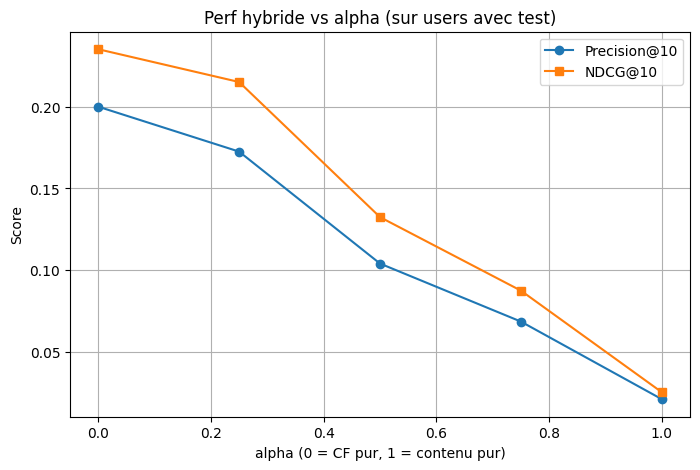

In [14]:
import matplotlib.pyplot as plt

def evaluate_alpha_curve_train(user_ids, k=10, alphas=[0.0,0.25,0.5,0.75,1.0]):
    rows = []
    for a in alphas:
        m = evaluate_hybrid_train(user_ids, k=k, alpha=a)
        m["alpha"] = a
        rows.append(m)
    return pd.DataFrame(rows)

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
df_results = evaluate_alpha_curve_train(user_sample, k=10, alphas=alphas)
print(df_results)

plt.figure(figsize=(8,5))
plt.plot(df_results["alpha"], df_results["precision@k"], marker="o", label="Precision@10")
plt.plot(df_results["alpha"], df_results["ndcg@k"], marker="s", label="NDCG@10")
plt.xlabel("alpha (0 = CF pur, 1 = contenu pur)")
plt.ylabel("Score")
plt.title("Perf hybride vs alpha (sur users avec test)")
plt.legend(); plt.grid(True); plt.show()


Le collaboratif filtering surpasse largement l'approche content-based sur ce jeu de données MovieLens.
Les résultats révèlent une hiérarchie claire des approches :

CF pur (α=0) : Performance optimale (20% de précision)
Hybride léger : Dégradation progressive mais acceptable
Content pur (α=1) : Performance très faible (3% de précision)

Cette tendance s'explique par une limite fondamentale du content-based : se baser uniquement sur les genres est trop réducteur. Les utilisateurs ont des goûts nuancés que les métadonnées seules ne peuvent capturer. À l'inverse, le collaboratif capture les vraies corrélations comportementales entre films, même quand elles ne sont pas évidentes par les genres.

## Conclusion
Le système marche, mais le graphe montre que dans cette DataFrame (ML-100K), le CF item-based est déjà très fort, et le contenu (juste genres) est trop faible pour aider.